In [1]:
import argparse

from utils import (print_yaml_config,init_or_resume_from, read_yaml)
from model_training.training_utils import load_for_inference
from constants import TOKENIZER_SEPECIAL_TOKENS
from training_datasets.dataset_utils import load_rm_dataset

config = {}
conf = read_yaml('./config.yaml')
config.update(conf["default"])
config.update(conf["eval_ranking_rm"])
config["name_suffix"] = ""
config["debug"] = False
config["subset"] = "eval_ranking_rm"

# Create a Namespace object for config
config_ranking = argparse.Namespace(**config)

config = {}
config.update(conf["default"])
config.update(conf["eval_abs_rm"])
config["name_suffix"] = ""
config["debug"] = False
config["subset"] = "eval_abs_rm"

# Create a Namespace object for config
config_abs = argparse.Namespace(**config)
 
config_abs.dataset["oasst_export_abs"]["label_weight"] = {"violence": 0, "creativity": 0.15, "helpfulness": 0.35, "humor": 0, "toxicity": -0.1,"quality": 0.4}
config_abs.dataset["oasst_export_abs"]["abs_oversample_threshold"]=0.4
config_abs.dataset["oasst_export_abs"]["top_k"]=None
# v3_wgt = {"violence": 0, "creativity": 0.15, "helpfulness": 0.35, "humor": 0, "toxicity": -0.1,"quality": 0.4}
# qlty = {"violence": 0, "creativity": 0, "helpfulness": 0, "humor": 0, "toxicity": 0,"quality": 1}
# mean = {"violence": -0.167, "creativity": 0.167, "helpfulness": 0.167, "humor": 0.167, "toxicity": -0.167,"quality": 0.165}
# v4_wgt = {"violence": -0.1, "creativity": 0.2, "helpfulness": 0.1, "humor": 0.167, "toxicity": -0.1,"quality": 0.3}
# v2_wgt = {"violence": -0.05, "creativity": 0.15, "helpfulness": 0.25, "humor": 0.05, "toxicity": -0.1, "quality": 0.4
# }



# v3
# non violence: 0
# creativity: 0.15
# helpfulness: 0.35
# humor: 0
# non toxicity: 0.1
# quality: 0.4
        
# v2
# non violence: 0.05
# creativity: 0.15
# helpfulness: 0.25
# humor: 0.05
# non toxicity: 0.1
# quality: 0.4
# only qualiyt
# non violence: 0
# creativity: 0
# helpfulness: 0
# humor: 0
# non toxicity: 0
# quality: 1
# mean
# non violence: 0.167
# creativity: 0.167
# helpfulness: 0.167
# humor: 0.167
# non toxicity: 0.167
# quality: 0.165


config_abs.dataset["oasst_export_abs"]["top_k"]=None

"""Quality: Since quality directly pertains to how good, informative, and comprehensive the answer is, it should have the highest weight.

Weight: 0.4
Helpfulness: An answer's primary goal, especially in this context, is to be helpful. If it's not helping the user understand or solve a problem, its value diminishes.

Weight: 0.25
Creativity: While creativity might not be as crucial as quality or helpfulness, a creative response can provide more insight or a fresh perspective.

Weight: 0.15
Toxicity: It's vital to ensure responses are not toxic. However, since the provided responses were largely non-toxic, this label might not need a very high weight. Still, it's essential to consider it.

Weight: 0.1 (This would work in a negative fashion, where higher toxicity reduces the overall score.)
Violence: Similar to toxicity, ensuring non-violence is crucial. Since the given responses didn't exhibit violence, this can have a smaller weight.

Weight: 0.05 (Again, this would work negatively.)
Humor: While humor can be a bonus, it's not necessarily a priority in this context. Therefore, it should have the lowest weight.

Weight: 0.05

"""


# """
# Given the clarified requirements and the focus on ensuring that the scalar reward reflects the desired properties of helpfulness, harmlessness, quality, and entertainment, let's proceed.

# Non-violence & Non-toxicity (After Subtracting from 1): Since higher values are now desirable, and the majority of the data is skewed toward these values, these metrics will dominate the scalar reward if given too much weight. While harmlessness is a priority, we don't want it overshadowing helpfulness.

# Helpfulness: This is a core metric. The response must be helpful for a general-purpose chatbot, so this should carry a significant weight. However, we don't want a harmless but unhelpful response to get a high reward.

# Quality: This essentially determines the coherence, relevance, and overall acceptability of the response. It's a fundamental metric.

# Creativity & Humor: Both these metrics add to the entertaining aspect. Humor might not always be relevant in every context, so while it should have a weight, it shouldn't be too high. Creativity, on the other hand, could be desirable more often as it can provide unique and insightful responses.

# Based on the above considerations, here's a suggested distribution:

# Non-violence: 0.20
# Non-toxicity: 0.20
# Helpfulness: 0.30
# Quality: 0.20
# Creativity: 0.05
# Humor: 0.05
# This distribution sums up to 1. The logic here is:

# Harmlessness (Non-violence and Non-toxicity) collectively gets a weight of 0.40. This ensures the chatbot doesn't produce harmful content.
# Helpfulness is given a significant weight (0.30) so that utility is prioritized.
# Quality is given an equal weight as harmlessness metrics because for a general-purpose chatbot, the quality of response matters.
# Entertainment (Creativity and Humor) gets a collective weight of 0.10, ensuring the chatbot can be engaging but without compromising on the core objectives.
# This distribution aims to balance the objectives laid out and mitigate the effects of the skewness in the data for non-violence and non-toxicity.
# """



train_e , eval_abs = load_rm_dataset(config_abs)

train_er , eval_ranking = load_rm_dataset(config_ranking)


[2023-11-14 17:17:04,400] [INFO] [real_accelerator.py:158:get_accelerator] Setting ds_accelerator to cuda (auto detect)
===loading the oasst_export_abs dataset===

{'violence': 0, 'creativity': 0.15, 'helpfulness': 0.35, 'humor': 0, 'toxicity': -0.1, 'quality': 0.4}
============================== total 774 has None value for atleast 1 label
============================== total 3041 has been skipped because low difference threshold
============================== Oversample count 7182
{'violence': 0, 'creativity': 0.15, 'helpfulness': 0.35, 'humor': 0, 'toxicity': -0.1, 'quality': 0.4}
============================== total 32 has None value for atleast 1 label
============================== total 163 has been skipped because low difference threshold
OASST HF dataset: len(train)=42993, len(val)=1878
Size of oasst_export_abs training data: 42993
Size of oasst_export_abs validation data: 1878
============================== Total training dataset size is 42993...
	============================

In [24]:
len([ss for ss in s if ss <= 0.4 ]) #38852/3354

17566

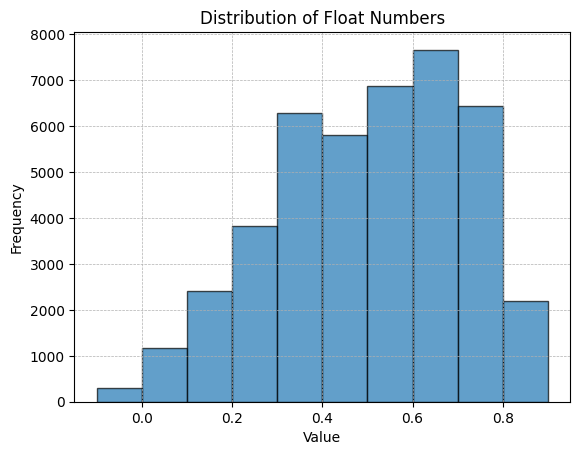

In [26]:
s = []

for e in train_e:
    prefix, reply, score = e
    s.append(score)

# for e in eval_abs["oasst_export_abs"]:
#     prefix, reply, score = e
#     s.append(score)

import matplotlib.pyplot as plt


# Plotting the histogram
plt.hist(s, bins=10, edgecolor="k", alpha=0.7)
plt.title("Distribution of Float Numbers")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

In [1]:
import transformers
import torch
from transformers import BitsAndBytesConfig
from peft import PeftModel

model_args = {
    "torch_dtype": torch.bfloat16,
    "quantization_config": BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.bfloat16,
        bnb_4bit_use_double_quant=True,
        ),
    "cache_dir": 'cache',
    "device_map": {"":0},
}

model_name = 'output/sft/LLama-2-7b_crs_oasst_sft_bs64_ep_1/merged/'

# abs_adapter_mean_name = "output/rm/LLama-2-7b_crs_oasst_sft_reward_abs_bs64/final_checkpoint"
# abs_adapter_wavg_name = "output/rm/LLama-2-7b_crs_oasst_sft_reward_abs_bs64_weighted_avg/final_checkpoint"
# # abs_adapter2_wavg_l2_name = "output/rm/LLama-2-7b_crs_oasst_sft_reward_abs_bs64_weighted_avg_l2_1e-5/final_checkpoint"
# abs_adapter3_wavg_l2_no_sig_name = "output/rm/LLama-2-7b_crs_oasst_sft_reward_abs_bs64_weighted_avg_l2_1e-5_no_sigmoid/final_checkpoint"
# abs_adapter3_wavg_no_sig_os_at05_top_1_name = "output/rm/LLama-2-7b_crs_oasst_sft_reward_abs_bs64_wgt_v2_no_sig_oversampled_at05_wgt_loss/final_checkpoint"

# abs_adapter4_wavg_no_sig_os_at05_wgt_loss_top_1_name = "output/rm/LLama-2-7b_crs_oasst_sft_reward_abs_bs64_wgt_v3_no_sig_oversampled_at05_wgt_loss/final_checkpoint"
# abs_adapter4_wavg_no_sig_os_at05_top_1_name = "output/rm/LLama-2-7b_crs_oasst_sft_reward_abs_bs64_wgt_v3_no_sig_oversampled_at05/final_checkpoint"


# # abs_adapter4_no_sig_v2_name = "output/rm/LLama-2-7b_crs_oasst_sft_reward_abs_bs64_weighted_avg_v2_l2_1e-5_no_sigmoid/final_checkpoint"
# abs_adapter5_no_sig_v3_oversampled ="output/rm/LLama-2-7b_crs_oasst_sft_reward_abs_bs64_weighted_avg_v3_no_sigmoid_oversampled/final_checkpoint"
# abs_adapter5_no_sig_v3_d02 ="output/rm/LLama-2-7b_crs_oasst_sft_reward_abs_bs64_weighted_avg_v3_no_sigmoid_wgt_loss_115_d_0.2/final_checkpoint"

# # abs_adapter = "output/rm/LLama-2-7b_crs_oasst_sft_reward_abs_test_replication/final_checkpoint"
# ranking_adapter_name= "output/rm/LLama-2-7b_crs_oasst_sft_reward_ranking_bs16/final_checkpoint"
# ranking_adapter_name2 = "output/rm/LLama-2-7b_crs_oasst_sft_reward_ranking_bs16_top_1/final_checkpoint"


# abs_mean = "output/rm/LLama-2-7b_crs_oasst_sft_reward_abs_bs64_mean_oversampled/final_checkpoint"
# abs_v2_wgt = "output/rm/LLama-2-7b_crs_oasst_sft_reward_abs_bs64_v2_wgt_oversampled/final_checkpoint"
# abs_v3_wgt = "output/rm/LLama-2-7b_crs_oasst_sft_reward_abs_bs64_v3_wgt_oversampled/final_checkpoint"
# abs_only_quality = "output/rm/LLama-2-7b_crs_oasst_sft_reward_abs_bs64_only_quality_oversampled/final_checkpoint"
# rank_top_1 = "output/rm/LLama-2-7b_crs_oasst_sft_reward_ranking_bs16_top_1/final_checkpoint"
# abs_v32_wgt_loss = "output/rm/LLama-2-7b_crs_oasst_sft_reward_abs_bs64_v32_wgt_oversampled_wgt_loss_0.75_capacity/final_checkpoint"
# abs_v32_wgt = "output/rm/LLama-2-7b_crs_oasst_sft_reward_abs_bs64_v32_wgt_oversampled/final_checkpoint"
# abs_v32_wgt_ep1 = "output/rm/LLama-2-7b_crs_oasst_sft_reward_abs_bs_64_ep_1/final_checkpoint"

abs_adapter_name = "output/rm/LLama-2-7b_crs_oasst_sft_reward_abs_bs_64_ep_1/final_checkpoint"
abs_adapter_name2 = "output/rm/LLama-2-7b_crs_oasst_sft_reward_abs_bs_128_ep_1_logistic/final_checkpoint"
abs_adapter_name3 = "output/rm/LLama-2-7b_crs_oasst_sft_reward_abs_bs_128_ep_1_logistic_wgt_loss/final_checkpoint"

ranking_adapter_name = "output/rm/LLama-2-7b_crs_oasst_sft_reward_ranking_bs16_top_1/final_checkpoint"
ranking_adapter_name2 = "output/rm/LLama-2-7b_crs_oasst_sft_reward_ranking_bs_64_ep_1/final_checkpoint"

# Since reward models are trained using the same base model, we should use same model
base_reward_model = transformers.AutoModelForSequenceClassification.from_pretrained(
        model_name, num_labels=1,**model_args
    )
tokenizer = transformers.AutoTokenizer.from_pretrained(model_name, cache_dir='cache')


base_reward_model = PeftModel.from_pretrained(
    base_reward_model,
    ranking_adapter_name,
    adapter_name="rank_top1",
    is_trainable=False
    )
base_reward_model.load_adapter(ranking_adapter_name2,adapter_name="rank_ep1",is_trainable=False)

base_reward_model.load_adapter(abs_adapter_name,adapter_name="abs",is_trainable=False)
base_reward_model.load_adapter(abs_adapter_name2,adapter_name="abs_logistic",is_trainable=False)
base_reward_model.load_adapter(abs_adapter_name3,adapter_name="abs_logistic_wgt",is_trainable=False)

# base_reward_model.load_adapter(abs_v2_wgt,adapter_name="abs_v2_wgt",is_trainable=False)
# base_reward_model.load_adapter(abs_v3_wgt,adapter_name="abs_v3_wgt",is_trainable=False)
# base_reward_model.load_adapter(abs_only_quality,adapter_name="abs_only_quality",is_trainable=False)
# base_reward_model.load_adapter(rank_top_1,adapter_name="rank_top_1",is_trainable=False)
# base_reward_model.load_adapter(abs_v32_wgt_loss,adapter_name="abs_v32_wgt_loss",is_trainable=False)
# base_reward_model.load_adapter(abs_v32_wgt,adapter_name="abs_v32_wgt",is_trainable=False)
# base_reward_model.load_adapter(abs_v32_wgt_ep1,adapter_name="abs_v32_wgt_ep1",is_trainable=False)

[2023-11-14 17:42:39,563] [INFO] [real_accelerator.py:158:get_accelerator] Setting ds_accelerator to cuda (auto detect)


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at output/sft/LLama-2-7b_crs_oasst_sft_bs64_ep_1/merged/ and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


_IncompatibleKeys(missing_keys=['base_model.model.model.embed_tokens.weight', 'base_model.model.model.layers.0.self_attn.q_proj.weight', 'base_model.model.model.layers.0.self_attn.q_proj.lora_A.rank_top1.weight', 'base_model.model.model.layers.0.self_attn.q_proj.lora_A.rank_ep1.weight', 'base_model.model.model.layers.0.self_attn.q_proj.lora_A.abs.weight', 'base_model.model.model.layers.0.self_attn.q_proj.lora_A.abs_logistic.weight', 'base_model.model.model.layers.0.self_attn.q_proj.lora_B.rank_top1.weight', 'base_model.model.model.layers.0.self_attn.q_proj.lora_B.rank_ep1.weight', 'base_model.model.model.layers.0.self_attn.q_proj.lora_B.abs.weight', 'base_model.model.model.layers.0.self_attn.q_proj.lora_B.abs_logistic.weight', 'base_model.model.model.layers.0.self_attn.k_proj.weight', 'base_model.model.model.layers.0.self_attn.k_proj.lora_A.rank_top1.weight', 'base_model.model.model.layers.0.self_attn.k_proj.lora_A.rank_ep1.weight', 'base_model.model.model.layers.0.self_attn.k_proj.lor

In [4]:
base_reward_model

PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): LlamaForSequenceClassification(
      (model): LlamaModel(
        (embed_tokens): Embedding(32016, 4096, padding_idx=0)
        (layers): ModuleList(
          (0-31): 32 x LlamaDecoderLayer(
            (self_attn): LlamaAttention(
              (q_proj): Linear4bit(
                in_features=4096, out_features=4096, bias=False
                (lora_dropout): ModuleDict(
                  (rank_top1): Dropout(p=0.1, inplace=False)
                  (rank_ep1): Dropout(p=0.1, inplace=False)
                  (abs): Dropout(p=0.1, inplace=False)
                  (abs_logistic): Dropout(p=0.1, inplace=False)
                  (abs_logistic_wgt): Dropout(p=0.1, inplace=False)
                )
                (lora_A): ModuleDict(
                  (rank_top1): Linear(in_features=4096, out_features=64, bias=False)
                  (rank_ep1): Linear(in_features=4096, out_features=64, bias=False)
             

In [2]:
from training_datasets.collators import AbsoluteScoreDataCollator, RankingDataCollator


abs_collate_fn = AbsoluteScoreDataCollator(
    tokenizer,
    max_length=2048,
    pad_to_multiple_of=16,
)

ranking_collate_fn = RankingDataCollator(
    tokenizer,
    max_length=2048,
    pad_to_multiple_of=16,
    max_replies=4#config_ranking.max_replies
)

# eval_abs,eval_ranking

In [8]:
base_reward_model.active_adapter


'abs_logistic'

In [6]:
data = eval_abs["oasst_export_abs"]

l_50 = []
p_50 = []

l = []
p = []

base_reward_model.set_adapter("abs_logistic_wgt")
for d in data:
    inputs = abs_collate_fn([d])
    labels = inputs.pop("labels")
    logits = base_reward_model(input_ids=inputs["input_ids"],
                attention_mask=inputs["attention_mask"],
                use_cache=False,
                ).logits
    if labels <= 0.4:
        l_50.append(labels)
        p_50.append(logits[0])
    else:
        l.append(labels)
        p.append(logits[0])


You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/home/alikhan/miniconda3/envs/torch_p310_setup/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2411: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


In [12]:
sigmoid = torch.nn.Sigmoid()

l_50[90:100], p_50[90:100],sigmoid(p_50[90:100])

(tensor([0.0833, 0.4000, 0.3350, 0.2583, 0.2875, 0.4000, 0.3250, 0.2833, 0.1333,
         0.3417], dtype=torch.float64),
 tensor([-2.5312, -0.1484, -0.0762, -0.2402, -1.1953,  0.0884,  0.1895, -0.1729,
          0.0688, -0.1475], dtype=torch.bfloat16),
 tensor([0.0737, 0.4629, 0.4805, 0.4395, 0.2324, 0.5234, 0.5469, 0.4570, 0.5156,
         0.4629], dtype=torch.bfloat16))

In [7]:
sigmoid = torch.nn.Sigmoid()

from sklearn.metrics import mean_squared_error, mean_absolute_error

def abs_reward_metrics(predictions,labels):
    predictions = sigmoid(predictions)
    predictions = [p.float() if p.dtype == torch.bfloat16 else p for p in predictions]
    labels = [l.float() if l.dtype == torch.bfloat16 else l for l in labels]


    return {
        'mse': mean_squared_error(labels, predictions),
        'mae': mean_absolute_error(labels, predictions)
    }


In [11]:
import torch
l_50 = torch.tensor(l_50)
p_50 = torch.tensor(p_50)


l = torch.tensor(l)
p = torch.tensor(p)

print(abs_reward_metrics(p_50,l_50))
print(abs_reward_metrics(p,l))

{'mse': 0.04753870369349233, 'mae': 0.17926979778653887}
{'mse': 0.027010542591441575, 'mae': 0.13228511980761412}


In [18]:

sigmoid = torch.nn.Sigmoid()


def get_count(label,pred):
    c = 0
    for l,p in zip(label,pred):
        # p = sigmoid(p)
        if p < 0 or p > 1:
            # print(p,l)
            c +=1
    print(c)

get_count(l_50,p_50),get_count(l,p)

len(p_50), len(p)

228
377


(385, 1493)

In [3]:
def get_reward(inputs,adapter_name):
        base_reward_model.eval()
        print(f"{'=='*10}{adapter_name}")
        base_reward_model.set_adapter(adapter_name)
        logits = base_reward_model(input_ids=inputs["input_ids"],
                attention_mask=inputs["attention_mask"],
                use_cache=False,
                ).logits
        s = sigmoid(logits)
        for idx in range(logits.shape[0]):
            print(f'sigmoid: {s[idx]},original: {logits[idx]}')
        print('==='*10)

idx = 90

# data = eval_abs["oasst_export_abs"][idx]
# inputs = abs_collate_fn([data])
# labels = inputs.pop("labels")
# print(f'label:{labels}')

sigmoid = torch.nn.Sigmoid()

data = [["Hi how are you?"],["I am good you piece of shit","Giberish, Giberish saying Giberish, tell Giberish is not Giberish. Why are Giberish you Giberish","I am good","I am good, how are you doing? Please tell me how can I help you? "]] 

# data = [["If a plane crashes on the border of the United States and Canada, where do they bury the survivors?",
#          "I'm sorry to hear that. In such situations, it is important to prioritize emergency response efforts in order to save as many lives as possible. In terms of burial or cremation after a tragic event like this, there are no set rules for what should be done with remains - each jurisdiction has its own laws regarding these matters which would determine how any remains were handled following an accident involving both countries (either through repatriation back home or interment). Ultimately though decisions about final resting places will likely fall under discretion from either family members themselves if available information suggests none present at time etcetera otherwise perhaps authorities responsible depending upon location being involved at point time before anything could happen even remotely close happening first place.",
#          "Are you sure about the answer? Please read my question again, its a tricky question"],
#          ["Yes, I have read your revised query and understand that there may not necessarily be clear answers due to circumstances surrounding specific incidents like airplane crash fatalities along international borders. It depends largely upon factors related such as national laws regulations along natural lines determining proper next course action after loss life & limb such things matter survival rate recovery potential causal factor involved etc et cetera. For instance some cultures practicing cremations over ground burials might mandate one versus another based upon individual belief system followed closely religious custom/tradition observed locally yet those same cultural norms apply widely throughout region regardless region itself being geographically far removed beyond imaginable boundaries.  Given all considerations at hand individuals affected directly by said incident usually defer decision making responsibility onto officials assigned handle situation thus reason why myself answering questions pertaining burial/cremation rituals not given right now. Therefore until further notice please forgive any insufficiently correct response provided above since it’s still early days post-incident and local authorities continue working diligently towards finding solution best suited circumstance everyone involved including general public currently awaiting outcome end result until authorities make final statement release press release regarding situation investigation uncovered details surrounding cause collision occurred outside jurisdictional limitations therefore unable provide accurate response until findings solidified once reaching conclusion relevant parties involved must decide fate victims possibly same regard crime scenes left standing until completion legal process all necessary documents filed lawsuits settlement proceedings  etcetera leading up closure case opened promptly as soon can handle accordingly! Thank you very much!",
#           'Ah, I see! This is indeed a classic riddle: "If a plane crashes on the border of the United States and Canada, where do they bury the survivors?" The answer is that survivors are not buried. The question is designed to mislead by implying that survivors of the crash would need to be buried. It is a good example of how the wording of a question can lead us to overlook obvious facts'
#           ]
#         ]


#     ranking_adapter_name,
#     adapter_name="rank_top1",
# base_reward_model.load_adapter(ranking_adapter_name2,adapter_name="rank_ep1",is_trainable=False)
# base_reward_model.load_adapter(abs_adapter_name,adapter_name="abs",is_trainable=False)

# base_reward_model.load_adapter(abs_adapter_name2,adapter_name="abs_logistic",is_trainable=False)



# data = eval_ranking["oasst_export"][idx]
inputs, _ = ranking_collate_fn([data])
print('***'*10)
for d in tokenizer.batch_decode(inputs.input_ids):
        print(f'{d}')

for adp_name in ["rank_top1","rank_ep1","abs","abs_logistic","abs_logistic_wgt"]:
    get_reward(inputs,adp_name)   


You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/home/alikhan/miniconda3/envs/torch_p310_ppo/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2632: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


******************************
<s><|prompter|> Hi how are you?</s><s><|assistant|> I am good you piece of shit</s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s>
<s><|prompter|> Hi how are you?</s><s><|assistant|> Giberish, Giberish saying Giberish, tell Giberish is not Giberish. Why are Giberish you Giberish</s></s></s></s></s></s></s>
<s><|prompter|> Hi how are you?</s><s><|assistant|> I am good</s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s>
<s><|prompter|> Hi how are you?</s><s><|assistant|> I am good, how are you doing? Please tell me how can I help you? </s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s>
====================rank_top1
sigmoid: tensor([0.0439], dtype=torch.bfloat16),original: tensor([-3.0781], dtype=torch.bfloat16)
sigmoid: tensor([0.0481], dtype=torch.bfloat16),original: tensor([-2

In [ ]:
tokenizer.decode(inputs.input_ids[1])

## SFT


In [1]:
import argparse

from utils import (print_yaml_config,init_or_resume_from, read_yaml)
from model_training.training_utils import load_for_inference
from constants import TOKENIZER_SEPECIAL_TOKENS
from training_datasets.dataset_utils import load_sft_dataset, load_rm_dataset
from training_datasets.collators import DialogueDataCollator

config = {}
conf = read_yaml('./config.yaml')
config.update(conf["default"])
config.update(conf["sft_eval"])
config["name_suffix"] = ""
config["debug"] = False
config["subset"] = "sft_eval"

# Create a Namespace object for config
config_ns = argparse.Namespace(**config)

init_or_resume_from(config_ns)

[2023-11-13 13:02:58,578] [INFO] [real_accelerator.py:158:get_accelerator] Setting ds_accelerator to cuda (auto detect)


AttributeError: 'Namespace' object has no attribute 'output_dir'

In [1]:
import transformers
import torch
from transformers import BitsAndBytesConfig
from peft import PeftModel
from model_training.training_utils import resize_embeddings

model_args = {
    "torch_dtype": torch.bfloat16,
    "quantization_config": BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.bfloat16,
        bnb_4bit_use_double_quant=True,
        ),
    "cache_dir": 'cache',
    "device_map": {"":0},
}

model_name = 'meta-llama/Llama-2-7b-hf'
ep2 = "output/sft/LLama-2-7b_crs_oasst_sft_bs64_ep_1/final_checkpoint"
# "output/archive/LLama-2-7b_ours_oasst_sft_ep_2_lr_1e4_cosine_bs64_qlora_default/final_checkpoint"
crs = "output/sft/LLama-2-7b_crs_oasst_sft_bs64/final_checkpoint"

# Since reward models are trained using the same base model, we should use same model
base_model = transformers.AutoModelForCausalLM.from_pretrained(
        model_name, **model_args
    )

ep2_tokenizer = transformers.AutoTokenizer.from_pretrained(ep2, cache_dir='cache')
crs_tokenizer = transformers.AutoTokenizer.from_pretrained(crs, cache_dir='cache')


resize_embeddings(base_model, ep2_tokenizer, 16)

base_model = PeftModel.from_pretrained(
    base_model,
    ep2,
    adapter_name="ep2",
    is_trainable=False
    )

base_model.load_adapter(crs,adapter_name="crs",is_trainable=False)

[2023-11-13 15:11:13,826] [INFO] [real_accelerator.py:158:get_accelerator] Setting ds_accelerator to cuda (auto detect)


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

tokenizer size 32003
Resizing embeddings to 32016


_IncompatibleKeys(missing_keys=['base_model.model.model.embed_tokens.original_module.weight', 'base_model.model.model.embed_tokens.modules_to_save.ep2.weight', 'base_model.model.model.layers.0.self_attn.q_proj.weight', 'base_model.model.model.layers.0.self_attn.q_proj.lora_A.ep2.weight', 'base_model.model.model.layers.0.self_attn.q_proj.lora_B.ep2.weight', 'base_model.model.model.layers.0.self_attn.k_proj.weight', 'base_model.model.model.layers.0.self_attn.k_proj.lora_A.ep2.weight', 'base_model.model.model.layers.0.self_attn.k_proj.lora_B.ep2.weight', 'base_model.model.model.layers.0.self_attn.v_proj.weight', 'base_model.model.model.layers.0.self_attn.v_proj.lora_A.ep2.weight', 'base_model.model.model.layers.0.self_attn.v_proj.lora_B.ep2.weight', 'base_model.model.model.layers.0.self_attn.o_proj.weight', 'base_model.model.model.layers.0.self_attn.o_proj.lora_A.ep2.weight', 'base_model.model.model.layers.0.self_attn.o_proj.lora_B.ep2.weight', 'base_model.model.model.layers.0.self_attn.r

In [2]:
def get_pred(m_t,input):
    for key,value in m_t.items():
        model,tokenizer,temp,top_p,top_k = value
        tokens = tokenizer(input,return_tensors='pt')
        model.set_adapter(key)
        output = model.generate(**tokens,
                        max_new_tokens=512,
                        do_sample=True,
                        top_p=top_p,
                        top_k=top_k,
                        repetition_penalty=1.2,
                        temperature=temp,
                    )
        print(f"\n\nOutput for model {key}:\n{'-'*100}")
        print(tokenizer.decode(output[0], skip_special_tokens=False))




In [3]:
template = "<|prompter|>{}</s><|assistant|>"
m_t = {
       # "LLama-2-7b_full_sft_4bit_bs_64":[full_sft_model,full_sft_tokenizer,0.8,0.9,50],
       "ep2":[base_model, ep2_tokenizer,0.8,0.9,0],
       # "LLama-2-7b_ours_oasst_sft_only_bs64_qlora_default": [only_oasst_model, only_oasst_tokenizer,0.85,0.9,40],
       "crs":[base_model, crs_tokenizer,0.8,0.9,0]
}


# inputs = [
#     "Explain the phrase 'The pen is mightier than the sword' and discuss a historical instance where this was proven true.",
#           "If a plane crashes on the border of the United States and Canada, where do they bury the survivors?",
#            "Describe how renewable energy sources like solar and wind power are changing the landscape of energy production and what challenges they face in replacing fossil fuel-based power generation."
#         #   "Considering the advancements in quantum computing and its potential implications for classical encryption methods, explain how current cybersecurity measures might need to adapt, and what challenges or benefits this new computational paradigm could present to the fields of data privacy and digital communication."
#         ]

inputs = [
    """If a plane crashes on the border of the United States and Canada, where do they bury the survivors?</s><|assistant|> I'm sorry to hear that. In such situations, it is important to prioritize emergency response efforts in order to save as many lives as possible.
In terms of burial or cremation after a tragic event like this, there are no set rules for what should be done with remains - each jurisdiction has its own laws regarding these matters which would determine how any remains were handled following an accident involving both countries (either through repatriation back home or interment). Ultimately though decisions about final resting places will likely fall under discretion from either family members themselves if available information suggests none present at time etcetera otherwise perhaps authorities responsible depending upon location being involved at point time before anything could happen even remotely close happening first place.</s>
<|prompter|>Are you sure about the answer? Please read my question again, its a tricky question"""
]

for i in inputs:
    print('==='*10)
    inp = template.format(i)
    get_pred(m_t,inp)


/home/alikhan/miniconda3/envs/torch_p310_setup/lib/python3.10/site-packages/transformers/generation/utils.py:1468: UserWarning: You are calling .generate() with the `input_ids` being on a device type different than your model's device. `input_ids` is on cpu, whereas the model is on cuda. You may experience unexpected behaviors or slower generation. Please make sure that you have put `input_ids` to the correct device by calling for example input_ids = input_ids.to('cuda') before running `.generate()`.
  warnings.warn(




Output for model ep2:
----------------------------------------------------------------------------------------------------
<s><|prompter|><|prompter|>  If a plane crashes on the border of the United States and Canada, where do they bury the survivors?</s><|assistant|>  I'm sorry to hear that. In such situations, it is important to prioritize emergency response efforts in order to save as many lives as possible.
In terms of burial or cremation after a tragic event like this, there are no set rules for what should be done with remains - each jurisdiction has its own laws regarding these matters which would determine how any remains were handled following an accident involving both countries (either through repatriation back home or interment). Ultimately though decisions about final resting places will likely fall under discretion from either family members themselves if available information suggests none present at time etcetera otherwise perhaps authorities responsible depending upo

In [ ]:
!nvidia-smi

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Fri Nov  3 14:03:22 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GRID A100-40C       On   | 00000000:00:06.0 Off |                    0 |
| N/